<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/real_data_drift_test_0921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Default Prediction - Neural Network

References

*   Learning under Concept Drift: A Review (https://www.usenix.org/system/files/sec21summer_yang.pdf)
*   G. Ditzler, M. Roveri, C. Alippi, and R. Polikar, “Learning in
nonstationary environments: a survey,” IEEE Comput. Intell. Mag.,
vol. 10, no. 4, pp. 12–25, 2015. (https://ieeexplore.ieee.org/document/7296710)
*   Concept Drift Detection in Data Stream Mining: The Review of
Contemporary Literature (https://core.ac.uk/download/pdf/231150802.pdf)
*   Early Drift Detection Method (https://www.cs.upc.edu/~abifet/EDDM.pdf)
*   https://en.wikipedia.org/wiki/Concept_drift
*  A Survey on Concept Drift Adaptation (https://www.win.tue.nl/~mpechen/publications/pubs/Gama_ACMCS_AdaptationCD_accepted.pdf)









Concept drift는 p(y|X) 에서, y와 X의 상관관계의 변화가 발생하는 경우를 의미 한다.

즉, 현실의 y와 X의 상관관계는 변화 하는데, 모델의 p(y^|X)는 변화하지 않으면서, 예측의 성능이 저하된다.

Concept drift의 발생 과정을 다음과 같이 구분 할 수 있다. (Bayes' theorem의 3개 term에 준하여 설명)

1. y 자체(p(y))가 바뀌는 경우, 예를 들어 정책 (rule)에 의해 바뀌는 경우. 논문 (B. Ramakrishna & Dr. S Krishna Mohan Rao, 2017, "Concept Drift Detection in Data Stream Mining: The Review of Contemporary Literature")에서는, "1) Drift by **prior probability** (a change in learnt decision boundary):" 으로 표현하고 있다. 

2. X가 변화 하면서 (Data drift), 결정경계 (decision boundry)를 넘게 될 때



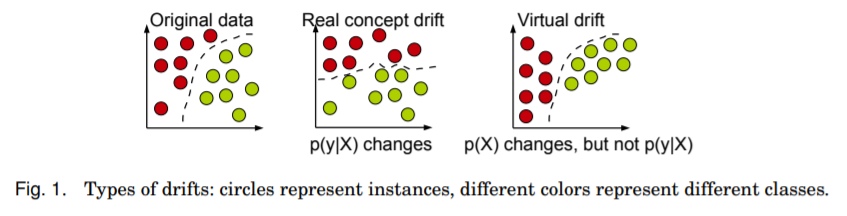

그림인용 :JOAO GAMA, 2017, "A Survey on Concept Drift Adaptation"


위의 그림에서, Virtual drift = Data drift before concept drift, 상황에서 그 정도가 심해지고, 결정경계가 변화 (중간. Real concept drift) 할 수 있다.

논문 (B. Ramakrishna & Dr. S Krishna Mohan Rao, 2017, "Concept Drift Detection in Data Stream Mining: The Review of Contemporary Literature")에서는, "2) Drift by **condition** (decision boundary change influenced by condition)" 으로 표현하고 있다.

3. X의 dimension이 변화, 특히 줄어드는 경우가 아닌 증가 하는 경우, 더 이상 X는 y를 설명 할 수 없다. 이러한 경우는 새로운 X의 dimension을 찾아야 한다.
 -> 어떻게 detect 할 것 인가????

논문 (B. Ramakrishna & Dr. S Krishna Mohan Rao, 2017, "Concept Drift Detection in Data Stream Mining: The Review of Contemporary Literature")에서는, "3) Drift by **posterior probability** (a change influenced by the conflict of old and new decision boundary):" 으로 표현하고 있다.


1과 2의 경우, 1,2의 내용이 포함된 새로운 정상성 데이터셋(stationary dataset)에 의해 다시 학습하면 예측성능을 회복 할 수 있다. 그러나 3의 경우, 우리가 갖고 있는 데이터는 이미 (non-stationary)한 상태로서 labeling을 하고 다시 학습하여도 예측성능을 회복 할 수 없다.

https://www.kaggle.com/errearanhas/default-prediction-neural-network-99-acc

##Introduction

Using historical data on loans from Lendig Club - including information on whether or not the borrower defaulted (charge-off) - the main objective of this notebook will be to predict if a potential borrower is likely to pay back the loan.

After explore and pre-process data, we are going to train a Neural Network binary classification model in order to achive this objective. Finally, we evaluate model performance and simulate its operation with a new customer prediction.

Notebook sections:

1. Import data
2. Exploratory Data Analysis
3. Pre-processing
4. Define and train Model
5. Evaluate Model

p.s. work inspired by the excellent Tf2 and Keras DL Bootcamp

In [ ]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

     |████████████████████████████████| 356 kB 6.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491649 sha256=4a14133b4dd79497ddde1be8ed1e279374aa69bc626fffc89d9611ece075efca
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 207 kB 8.0 MB/s 
     |████████████████████████████████| 2.8 MB 85.4 MB/s 
     |████████████████████████████████| 4.8 MB 72.3 MB/s 
     |████████████████████████████████| 454.4 MB 8.6 kB/s 
     |████████████████████████████████| 462 kB 87.2 MB/s 
     |████████████████████████████████| 1.2 MB 55.8 MB/s 
     |████████████████████████████████| 4.0 MB 53.0 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
     |████████████████████████████████| 636 kB 73.4 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
  Attempting unin

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260701, 151)


##Exploratory Data Analysis (and some initial pre-processing)

Since we are going to predict loan_status, let's take a brief closer look on it:

In [ ]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

In [ ]:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


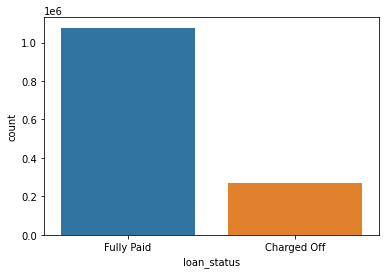

In [ ]:
sns.countplot(x="loan_status", data=df_accepted)

checking now null values per columns:

In [ ]:
df_accepted.isnull().sum().sort_values(ascending=False)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
hardship_flag                                       0
fico_range_high                                     0
id                                                  0
Length: 151, dtype: int64

wow, there is a bunch of columns almost full of missing values. Let's check the first 50 columns sorted by missing values:

In [ ]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_length                               1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_last_payment_amount                  1339556
hardship_payoff_balance_amount                1339556
hardship_amount                               1339556
hardship_status                               1339556
hardship_reason                               1339556
hardship_type                                 1339556
deferral_term                                 1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

let's drop these columns, as it will not contribute to our goal.

In [ ]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

let's check again:

In [ ]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

open_il_24m                   807712
inq_fi                        807712
open_rv_24m                   807712
open_rv_12m                   807712
open_act_il                   807712
max_bal_bc                    807712
total_bal_il                  807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
mo_sin_rcnt_rev_tl_op          67528
mo_sin_rcnt_tl                 67527
num_accts_ever_120_pd          67527
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_bc_tl                      67527
num_tl_op_past_12m             67527
num_tl_90g_dpd_24m             67527
total_il_high_credit_limit     67527
tot_coll_amt                   67527
t

maybe we can go further, and eliminate columns up to title:

In [ ]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [ ]:
print(df_accepted['issue_d'])

0          Dec-2015
1          Dec-2015
2          Dec-2015
4          Dec-2015
5          Dec-2015
             ...   
2260688    Oct-2016
2260690    Oct-2016
2260691    Oct-2016
2260692    Oct-2016
2260697    Oct-2016
Name: issue_d, Length: 1345310, dtype: object


for the remaining columns with missing values, let's see the missing percentage:

In [ ]:
nulls = df_accepted.isnull().sum().sort_values(ascending=False)
nulls_percentage = (nulls/df_accepted.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
collections_12_mths_ex_med    0.004163
chargeoff_within_12_mths      0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
zip_code                      0.000074
inq_last_6mths                0.000074
issue_d                       0.000000
addr_state                    0.000000
delinq_2yrs                   0.000000
earliest_cr_line              0.000000
purpose                       0.000000
dtype: float64

Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

In [ ]:
df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [ ]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

let's now take a look at loan_amnt histogram, to have an idea of the amount distribution:

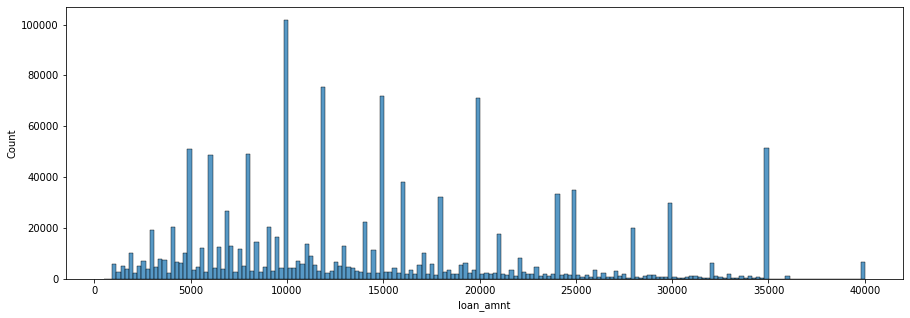

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(df_accepted.loan_amnt, kde=False)

let's now see the correlation between continuous variables:

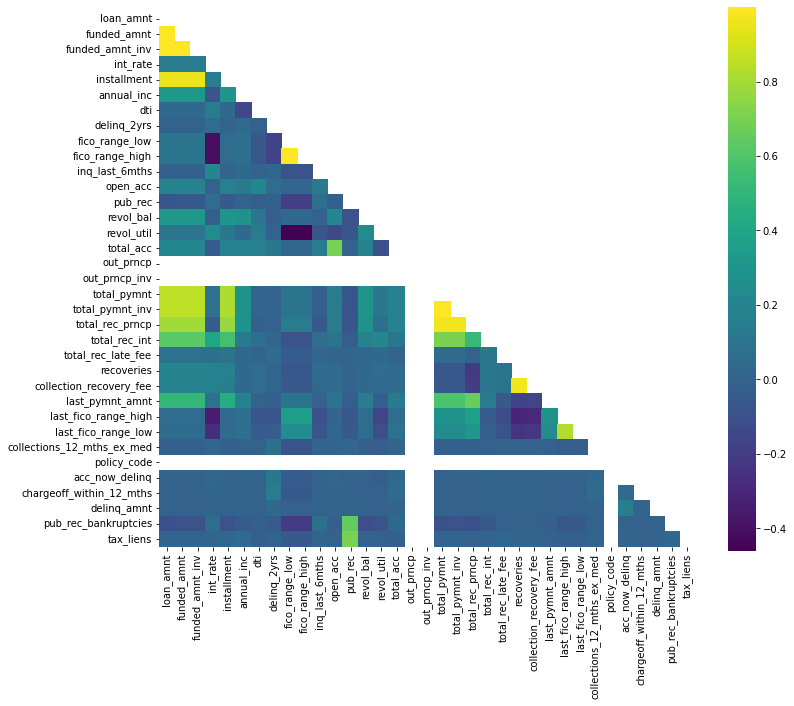

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

there are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code.

In [ ]:
print(df_accepted.out_prncp.value_counts())
print(df_accepted.out_prncp_inv.value_counts())
print(df_accepted.policy_code.value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


These are constant columns. We can drop it either.

In [ ]:
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

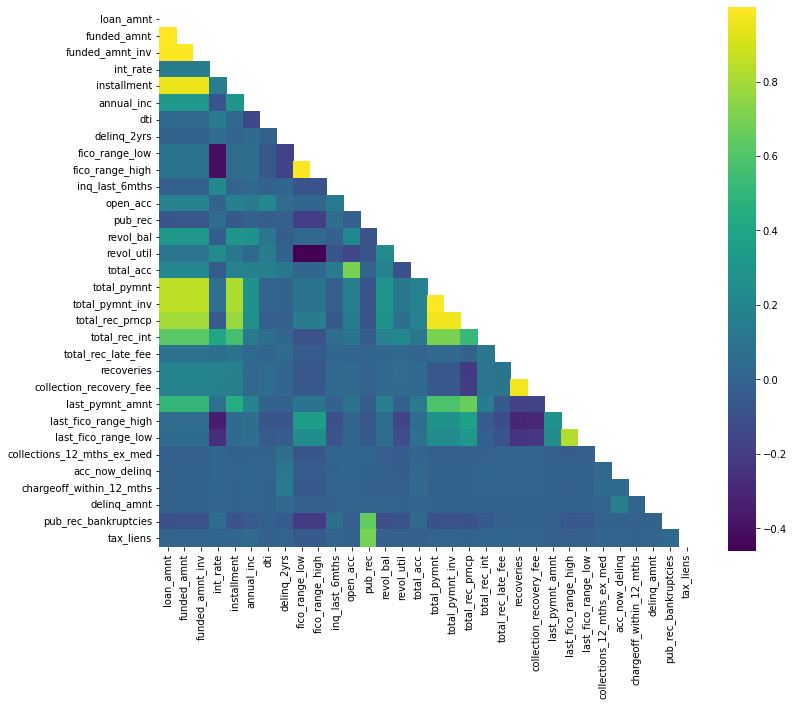

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

There are many yellowish squares. This indicates almost perfect correlation between many variables. Let's dig deeper:

In [ ]:
# unstacking correlation to check highest correlation pairs

c = df_accepted.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']


# check feature pairs above 0.8 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.80)

corr_pairs[cond1 & cond2]

feature1             feature2      corr
1           fico_range_high       fico_range_low  1.000000
2                 loan_amnt          funded_amnt  0.999565
3               total_pymnt      total_pymnt_inv  0.999541
4           funded_amnt_inv          funded_amnt  0.999439
5                 loan_amnt      funded_amnt_inv  0.998918
6   collection_recovery_fee           recoveries  0.972674
7           total_rec_prncp          total_pymnt  0.967104
8           total_rec_prncp      total_pymnt_inv  0.966725
9               funded_amnt          installment  0.954037
10          funded_amnt_inv          installment  0.953445
11                loan_amnt          installment  0.953387
12          funded_amnt_inv      total_pymnt_inv  0.857150
13              funded_amnt          total_pymnt  0.856901
14          total_pymnt_inv          funded_amnt  0.856675
15                loan_amnt          total_pymnt  0.856658
16              total_pymnt      funded_amnt_inv  0.856443
17          total_pymnt_inv            loan_amnt  0.856355
18     last_fico_range_high  last_fico_range_low  0.829740
19              installment          total_pymnt  0.818291
20          total_pymnt_inv          installment  0.818049

Let's perform scatterplot and visually check some relationships among these features:

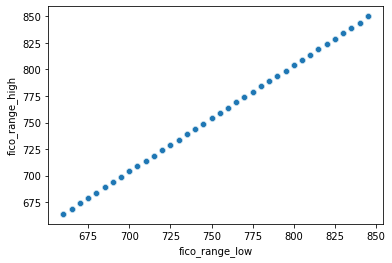

In [ ]:
sns.scatterplot(x=df_accepted.fico_range_low, y=df_accepted.fico_range_high)

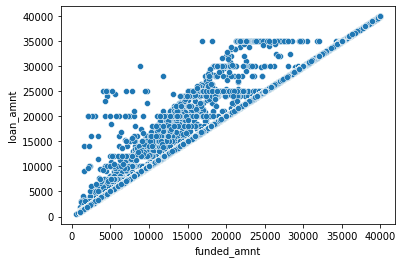

In [ ]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.loan_amnt)

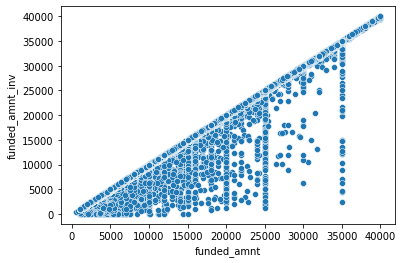

In [ ]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.funded_amnt_inv)

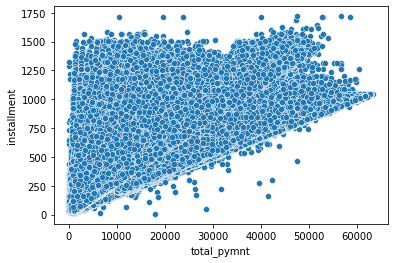

In [ ]:
sns.scatterplot(x=df_accepted.total_pymnt, y=df_accepted.installment)

It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

In [ ]:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

as our target column is categorical (loan_status), let's create a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [ ]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

In [ ]:
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

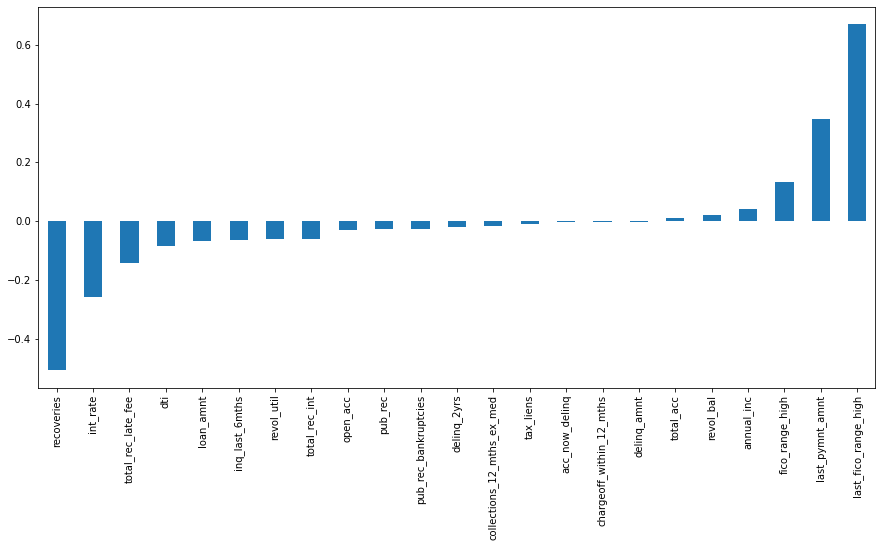

In [ ]:
# checking correlation of features to the new loan_paid column


plt.figure(figsize=(15,7))
new_corr = df_accepted.corr().iloc[:-1,-1].sort_values()
new_corr.plot.bar(rot=90)

##Pre-processing

we still have many string categorical columns. Let's work on it:

In [ ]:
df_accepted

loan_amnt  term  int_rate  annual_inc  ... OWN  RENT  DirectPay  Y
0           9000.0    36     12.49    39000.00  ...   0     0          0  0
1          12375.0    36     10.91    80000.00  ...   0     1          0  0
2          12000.0    36      9.01   100671.39  ...   0     0          0  0
3           7000.0    36     10.59    63500.00  ...   0     0          0  0
4           4800.0    36     10.28    35000.00  ...   0     1          0  0
...            ...   ...       ...         ...  ...  ..   ...        ... ..
1341021    10000.0    60     13.56    40000.00  ...   0     1          0  0
1341022    14400.0    60     11.80   120000.00  ...   0     0          1  0
1341023     5000.0    36     16.14    45000.00  ...   0     1          0  0
1341024    30000.0    60     17.97    99936.00  ...   0     0          0  0
1341025     3500.0    36     10.33    58000.00  ...   0     1          0  0

[1341026 rows x 83 columns]

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)
df_accepted[cat_cols]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


id        term  ... disbursement_method debt_settlement_flag
0        68407277   36 months  ...                Cash                    N
1        68355089   36 months  ...                Cash                    N
2        68341763   60 months  ...                Cash                    N
4        68476807   60 months  ...                Cash                    N
5        68426831   36 months  ...                Cash                    N
...           ...         ...  ...                 ...                  ...
2260688  89905081   60 months  ...                Cash                    N
2260690  88948836   60 months  ...                Cash                    N
2260691  89996426   60 months  ...                Cash                    N
2260692  90006534   60 months  ...                Cash                    N
2260697  88224441   60 months  ...                Cash                    Y

[1341026 rows x 20 columns]

In [ ]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


In [ ]:
print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [ ]:
print(df_accepted.grade.value_counts())
print(df_accepted.sub_grade.value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64
C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


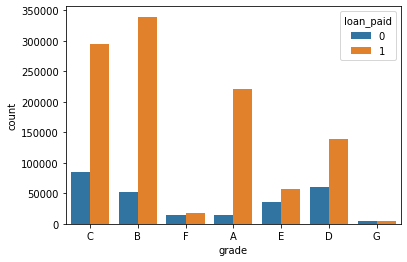

In [ ]:
# checking count per grade and loan_paid

sns.countplot(x=df_accepted.grade, hue=df_accepted.loan_paid)

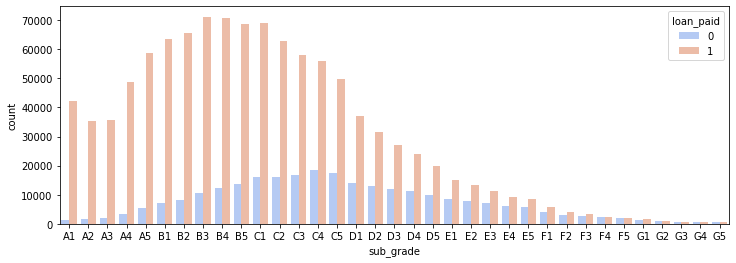

In [ ]:
# checking count per subgrade and loan_paid

l = list(df_accepted.sub_grade.unique())
l.sort()

plt.figure(figsize=(12,4))
sns.countplot(x=df_accepted.sub_grade, order=l, hue=df_accepted.loan_paid, palette='coolwarm')

In [ ]:
# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

In [ ]:
df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


features verification_status, application_type, initial_list_status, purpose

In [ ]:
print(df_accepted.verification_status.unique())
print(df_accepted.application_type.unique())
print(df_accepted.initial_list_status.unique())
print(df_accepted.purpose.unique())

['Not Verified' 'Source Verified' 'Verified']
['Individual' 'Joint App']
['w' 'f']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


In [ ]:
# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

In [ ]:
df_accepted

loan_amnt  term  int_rate  ... small_business  vacation wedding
0           3600.0    36     13.99  ...              0         0       0
1          24700.0    36     11.99  ...              1         0       0
2          20000.0    60     10.78  ...              0         0       0
4          10400.0    60     22.45  ...              0         0       0
5          11950.0    36     13.44  ...              0         0       0
...            ...   ...       ...  ...            ...       ...     ...
2260688    18000.0    60      9.49  ...              0         0       0
2260690    29400.0    60     13.99  ...              0         0       0
2260691    32000.0    60     14.49  ...              0         0       0
2260692    16000.0    60     12.79  ...              0         0       0
2260697    24000.0    60     14.49  ...              0         0       0

[1341026 rows x 86 columns]

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'issue_d', 'url', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


feature home_ownership

In [ ]:
df_accepted.home_ownership.value_counts()

MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: home_ownership, dtype: int64

In [ ]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

features issue_d, url, last_pymnt_d and last_credit_pull_d

--> 여기서는 issue_d column을 drop 했지만... 우리는 이걸 살린다!!!

In [ ]:
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])

In [ ]:
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])

In [ ]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['issue_d', 'earliest_cr_line', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


features disbursement_method and debt_settlement_flag

In [ ]:
print(df_accepted.disbursement_method.value_counts())
print(df_accepted.debt_settlement_flag.value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


In [ ]:
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

feature earliest_cr_line

In [ ]:
print(df_accepted.earliest_cr_line.value_counts())

Aug-2001    9365
Aug-2002    9066
Sep-2003    9000
Oct-2001    8838
Aug-2000    8822
            ... 
Mar-1958       1
Mar-1957       1
Feb-1957       1
Jul-1955       1
Feb-1945       1
Name: earliest_cr_line, Length: 739, dtype: int64


In [ ]:
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

In [ ]:
df_accepted.shape

(1341026, 83)

In [ ]:
df_accepted

loan_amnt  term  int_rate  annual_inc  ... OWN  RENT  DirectPay  Y
0           3600.0    36     13.99     55000.0  ...   0     0          0  0
1          24700.0    36     11.99     65000.0  ...   0     0          0  0
2          20000.0    60     10.78     63000.0  ...   0     0          0  0
4          10400.0    60     22.45    104433.0  ...   0     0          0  0
5          11950.0    36     13.44     34000.0  ...   0     1          0  0
...            ...   ...       ...         ...  ...  ..   ...        ... ..
2260688    18000.0    60      9.49    130000.0  ...   1     0          0  0
2260690    29400.0    60     13.99    180792.0  ...   0     0          0  0
2260691    32000.0    60     14.49    157000.0  ...   0     0          0  0
2260692    16000.0    60     12.79    150000.0  ...   0     1          0  0
2260697    24000.0    60     14.49    110000.0  ...   0     1          0  1

[1341026 rows x 83 columns]

날짜 (issue_d) 정리 및 sort

In [ ]:
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

In [ ]:
def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

'200901'

In [ ]:
 df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
 df_accepted = df_accepted.sort_values(by='issue_d')
 df_accepted.reset_index(drop=True, inplace=True)

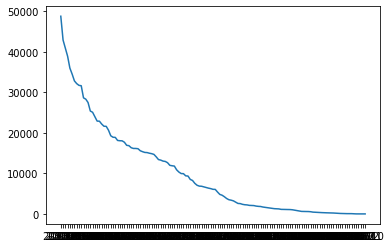

In [ ]:
plt.plot(df_accepted['issue_d'].value_counts())

In [ ]:
df_accepted[df_accepted['issue_d'].str.startswith('2009')]['issue_d'].value_counts()

200912    597
200911    595
200910    543
200909    445
200908    407
200907    372
200906    353
200905    319
200904    287
200903    275
200902    259
200901    236
Name: issue_d, dtype: int64

##Creating a Neural Network Model

now we are ready to start our modelling phase. First, let's apply a train-test-split and scale data before training.

2007,2008,2009 년도 데이터로 학습하고, 이후 각 년도별 Acc를 측정한다.

In [ ]:
X = {}
Y = {}

In [ ]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [ ]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [ ]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


각 년도별 학습

In [ ]:
ML = {}
scaler = MinMaxScaler()

In [ ]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [ ]:
MODEL_TYPE = 'RF'  ## RF / DL

## Deep Learning 모델

In [ ]:
import os.path 

def build_model_dl(year,x,y,epochs=5):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.fit_transform(x)
    #X_test = scaler.transform(X_test)
    y_train = get_one_hot(y,2)

    # building the model
    model = Sequential()
    model.add(Dense(units=78,activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=19,activation='relu'))
    model.add(Dense(units=8,activation='relu'))
    model.add(Dense(units=4,activation='relu'))
    model.add(Dense(units=2,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    weight_path = '/content/drive/MyDrive/Drift/model/ml_'+str(year)
    if os.path.exists(weight_path+'.index'):
        model.load_weights(weight_path)
        print('load weights from ',weight_path)
    else:
        model.fit(x=X_train, 
                y=y_train, 
                epochs=epochs,
                batch_size=512,
                verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
        if year > 2000:
            model.save_weights(weight_path) 
            print('save weights to ',weight_path)
    return model

## Rabdom forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(x,y)
    return model

## 년도별 모델 빌드

In [ ]:
%rm -f /content/drive/MyDrive/Drift/model/checkpoint

def build_models():
    for year in range(2009,2019):
        # building the model
        print(str(year) + '년도 학습 ======================================')
        epochs = 100 #(100 if year==2009 else 5)
        if MODEL_TYPE =='DL':
            ML[year] = build_model_dl(year,X[year],Y[year],epochs=epochs)
        else:
            ML[year] = build_model_rf(year,X[year],Y[year],epochs=epochs)
            

In [ ]:
build_models()

2009년도 학습 ======================================
2010년도 학습 ======================================
2011년도 학습 ======================================
2012년도 학습 ======================================
2013년도 학습 ======================================
2014년도 학습 ======================================
2015년도 학습 ======================================
2016년도 학습 ======================================
2017년도 학습 ======================================
2018년도 학습 ======================================


## Evaluate model

In [ ]:
metric = np.zeros((10,10))
mdf = pd.DataFrame(metric,columns=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'],index=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])


In [ ]:
# 2009년 학습으로 2010~2018년까지의 acc 비교
for model_year in range(2009,2019):
    print('model:',model_year)
    for year in range(2009,2019):
        print('\ttest:',year)
        X_test = scaler.fit_transform(X[year])
        if MODEL_TYPE =='DL':
            predictions = (ML[model_year].predict(X_test)[:,1] > 0.5).astype("int32")
        else:
            predictions = (ML[model_year].predict(X_test) > 0.5).astype("int32")
        acc = accuracy_score(Y[year], predictions)
        print('\tacc:',acc)
        mdf.iloc[year-2009,model_year-2009] = acc

mdf

model: 2009
	test: 2009


KeyError: ignored

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(mdf)
mask[np.triu_indices_from(mask)] = False
sns.heatmap(mdf, cmap='viridis', mask=mask, annot=False, square=True)

## shap에 의한 feature importance 분석

In [ ]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift

In [ ]:
REFERENCE_YEAR = 2009

In [ ]:
x_columns = list(df_accepted.columns)
x_columns.remove('loan_paid')
x_columns.remove('issue_d')

In [ ]:
def XAI(model,X_test,top=6):

    XAI_Explainer = None
    if MODEL_TYPE == 'DL':
        XAI_Explainer = shap.DeepExplainer
        xs = X_test[0:10]
        model(X_test)
    else:
        XAI_Explainer = shap.TreeExplainer
        xs = X_test

    explainer = XAI_Explainer(model,X_test)
    
    shap_values = explainer.shap_values(xs)
    vals= np.abs(shap_values).mean(0)*2
    feature_importance = {}
    for (fname,imp_val) in zip(x_columns,np.mean(vals,axis=0)):
        feature_importance[fname] = (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

    sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
    
    monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
    return feature_importance, monitoring_feature, shap_values

In [ ]:
def get_feature_importance(model,X_test,display=False):
    #model = ML[year]
    X_test = scaler.fit_transform(X_test)

    # ##### EXPLANATIONS #####
    print()
    print("Generating explanations...")
    
    df_x_test = pd.DataFrame(X_test,columns=x_columns)

    feature_importance, monitoring_feature, shap_values = XAI(model,X_test,top=5)
    print('monitoring_feature',monitoring_feature)
    if display:
        plt.figure(figsize=(30,15))
        shap.summary_plot(shap_values, df_x_test, show=False, class_names=['Fully pad','charge-off'])
        plt.grid()
        plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')
        plt.show()
    return feature_importance, monitoring_feature


Generating explanations...


100%|===================| 22954/22994 [00:17<00:00]       

monitoring_feature ['recoveries' 'debt_consolidation' 'Y' 'D2' 'other']


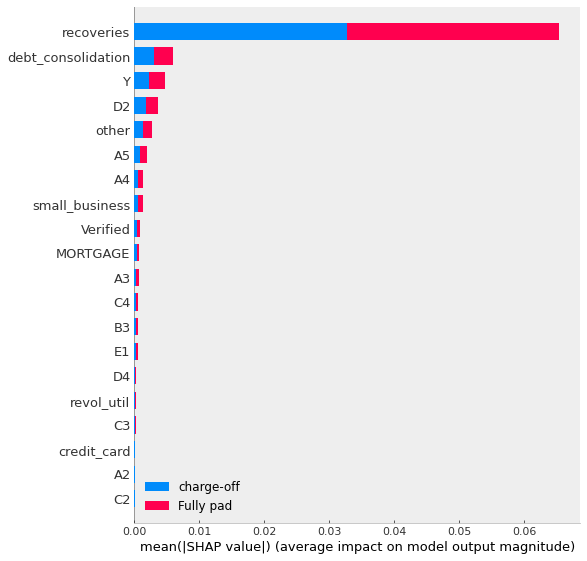

In [ ]:
feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR],display=True)

In [ ]:
model = ML[REFERENCE_YEAR]

importances = model.feature_importances_
forest_importances = pd.Series(importances, index=x_columns)

feature_importance = {}
for (fname,imp_val) in forest_importances.items():
    feature_importance[fname] = (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)


list(forest_importances.sort_values(ascending=False).keys()[0:5])

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'total_rec_int']

## Drift 측정

Reference년도의 train data를 기준으로 
bucket size, step size 를 변경하면서 
KS drift를 측정한다!

In [ ]:
import pickle

def scan_data(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]
    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in monitoring_feature:
        result_data[column + ' '] = []
        result_data[column + ' Drift'] = []
        result_data[column + ' p_val'] = []
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 1000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname + ' '].append(stat_val)
            result_data[fname + ' Drift'].append(is_drift)
            result_data[fname + ' p_val'].append(p_val)

            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 

            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname + ' '])-1,stat_val),p_val]

        drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())
        predict_out = model.predict(scaler.fit_transform(x_test_for_model))
        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')
            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].values
            cd = KSDrift(drift_ref, p_val=detect_p_val)
            y = df_reference.loan_paid.values
            x = df_reference.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)
            retrain_count += 1
            print()


    with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
        pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val]

## image 저장 도구들

In [ ]:
import pickle
with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "rb") as fp:
    a = pickle.load(fp)
    result_data = a[0]
    drift_point = a[1]
    drift_status = a[2]
    distribution_analysis = a[3]

In [ ]:

import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import glob

def generate_gif(path,output_file_name = 'out.gif'):
    img_list = os.listdir(path)
    img_list = [path + '/' + x for x in img_list if x.endswith(".png")]
    images = [Image.open(x) for x in img_list]
    
    im = images[0]
    im.save('out.gif', save_all=True, append_images=images[1:],loop=0xff, duration=200)
    # loop 반복 횟수
    # duration 프레임 전환 속도 (500 = 0.5초)
    return Img(url=output_file_name)

In [ ]:
%rm -f /content/drive/MyDrive/Drift/img/*.png

for cut in range(0,len(drift_status),10):

    status = drift_status[cut]
    drifted_columns = []
    fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(10,10) )  # create figure & 1 axis
    fig.suptitle('Feature importance vs Drift at time '+str(cut))
    plt.xlabel('Feature importance')
    plt.ylabel('Drift KPI')
    for fname in status.keys():
        (importance_value, drift, p_val, is_drift) = status[fname]
        if is_drift:
            drifted_columns.append(fname)
        ax.annotate(fname+':'+str(is_drift), (importance_value,drift),color=('red' if is_drift==1 else 'black'))
        ax.plot([importance_value],[drift],'o')
        ax.grid()
    fig.savefig('/content/drive/MyDrive/Drift/img/IvD_'+str(cut)+'.png')   # save the figure to file
    plt.close(fig)    # close the figure window

In [ ]:
gif = generate_gif('/content/drive/MyDrive/Drift/img')

## 측정의 chart 출력

In [ ]:
def plot_drift(scan_result,span = 10):

    result_data = scan_result[0]
    drift_point = scan_result[1]
    drift_status = scan_result[2]
    distribution_analysis = scan_result[3]
    start_index = scan_result[4]
    end_index = scan_result[5]
    p_val = scan_result[6]

    plt.style.use('bmh')
    #span = 10
    result_df = pd.DataFrame(result_data)
    result_df = result_df.dropna(axis=1,how='all')

    ax = result_df.drop(columns=['model performance','model confidence']).ewm(span = span).mean().plot(linewidth=1,figsize=(20,10))
    ax.set_title(f"ref_year {REFERENCE_YEAR} model {MODEL_TYPE} p_value {p_val} between {df_accepted[df_accepted.index==start_index]['issue_d'].values[0]}~{df_accepted[df_accepted.index==end_index]['issue_d'].values[0]}")
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("Drift")
    for fname in drift_point.keys():
        if fname.startswith(tuple(monitoring_feature)):
            p,p_val = drift_point[fname]
            plt.annotate(str(p_val), (p[0]-5,p[1]+0.02))
            plt.plot([p[0]],[p[1]],'o')
    ax_perf = ax.twinx()
    ax_perf.set_ylim(0.70, 1.0)
    ax_perf.set_ylabel("model performance")
    ax_perf.plot(result_df['model performance'].ewm(span = span).mean(),linewidth=2,label='model performance')
    ax_perf.plot(result_df['model confidence'].ewm(span = span).mean(),linewidth=1,label='model confidence')
    ax_perf.legend()
    #ax = result_df['model performance'].ewm(span = 10).mean().plot(linewidth=1,figsize=(20,10))

    ax.legend(bbox_to_anchor=(0.0, 1.0))
    ax.plot()
    plt.show()

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

## 실험들

실험

scan에서 Drift reference는 10만건으로 ...

In [ ]:
import pickle

def scan_data2(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]

    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=x_columns)

    feature_importance = {}
    for (fname,imp_val) in forest_importances.items():
        feature_importance[fname] = (imp_val,0,0,0) 
    monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
    print('monitoring_feature',monitoring_feature)
    #feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR])

    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)
    #model_cd = ClassifierDrift(scaler.fit_transform(df_reference.drop(columns=['issue_d','loan_paid']).values), model, p_val=.05, train_size=.75, epochs=1)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in x_columns:
        result_data[column] = []
        #result_data[column + ' Drift'] = []
        #result_data[column + ' p_val'] = []
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 5000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname].append(stat_val)
            #result_data[fname + ' Drift'].append(is_drift)
            #result_data[fname + ' p_val'].append(p_val)

            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 
            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname])-1,stat_val),p_val]

        for fname in x_columns:
            if fname not in monitoring_feature:
                result_data[fname].append(None)
                #result_data[fname + ' Drift'].append(None)
                #result_data[fname + ' p_val'].append(None)

        drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())

        x_h0 = scaler.fit_transform(x_test_for_model)
        '''
        preds = model_cd.predict(x_h0)
        print(preds)
        '''
        predict_out = model.predict(x_h0)

        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')

            '''
            # ref year의 데이터와 최근 20만건의 데이터를 합하여, 썩는다.
            df_model_ref = pd.concat([df_accepted[df_accepted['issue_d'].str.endswith(str(REFERENCE_YEAR))],df_reference[-200000:]])
            df_model_ref = df_model_ref.sample(frac=1)
            '''
            y = df_reference.loan_paid.values
            x = df_reference.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)

            importances = model.feature_importances_
            forest_importances = pd.Series(importances, index=x_columns)
            monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
            print('monitoring_feature',monitoring_feature)
            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].to_numpy()[-100000:]
            cd = KSDrift(drift_ref, p_val=detect_p_val)            
            retrain_count += 1
            print()


    with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
        pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val]

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2013 ==============================
 1100000/1102423 step 221 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8770 cfd 1.0000

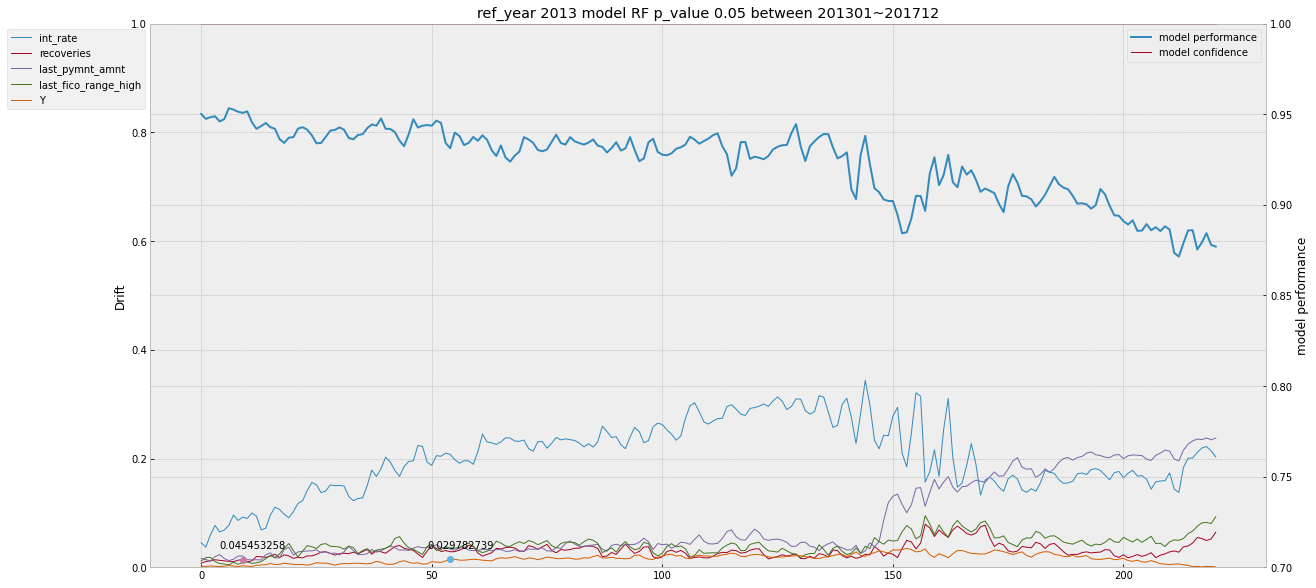

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2013 ==============================
 270000/1102423 step 55 day 201501 index 463053 model_ver 0 drift 5 acc 0.9313 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~463053, length 370825
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 705000/1102423 step 142 day 201603 index 898053 model_ver 1 drift 5 acc 0.9178 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~898053, length 805825
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 765000/1102423 step 154 day 201604 index 958053 model_ver 2 drift 5 acc 0.8933 cfd 1.0000
========================================

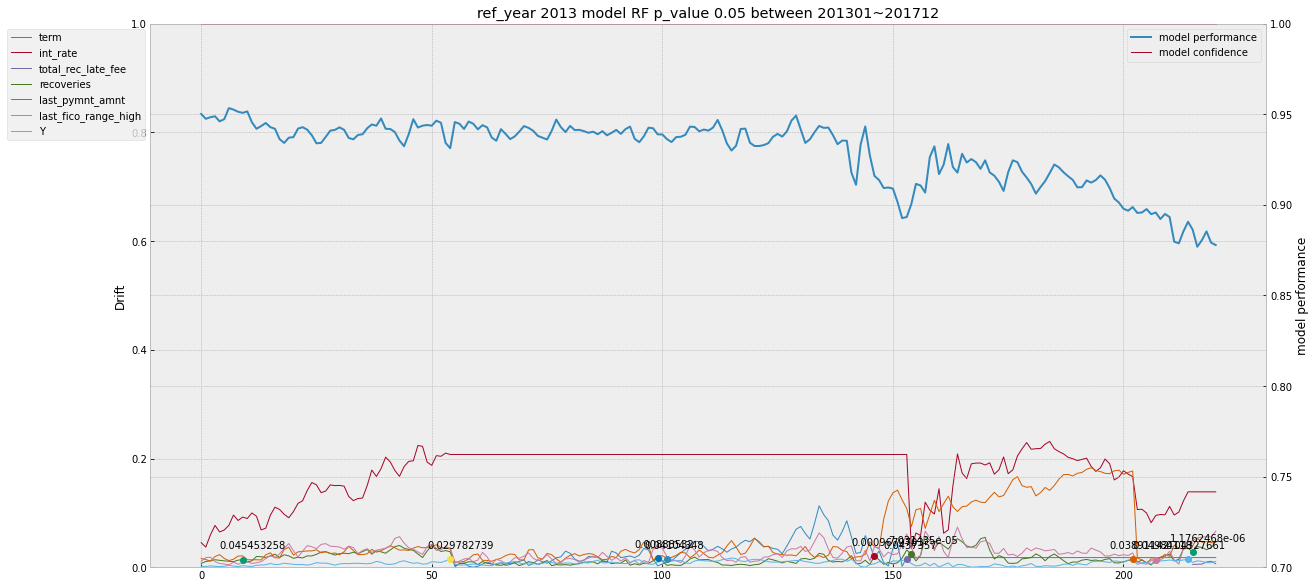

In [ ]:
REFERENCE_YEAR = 2013
scan_result = scan_data2(detect_p_val=0.05,is_do_retrain=False)
plot_drift(scan_result,span = 1)
scan_result = scan_data2(detect_p_val=0.05,is_do_retrain=True)
plot_drift(scan_result,span = 1)

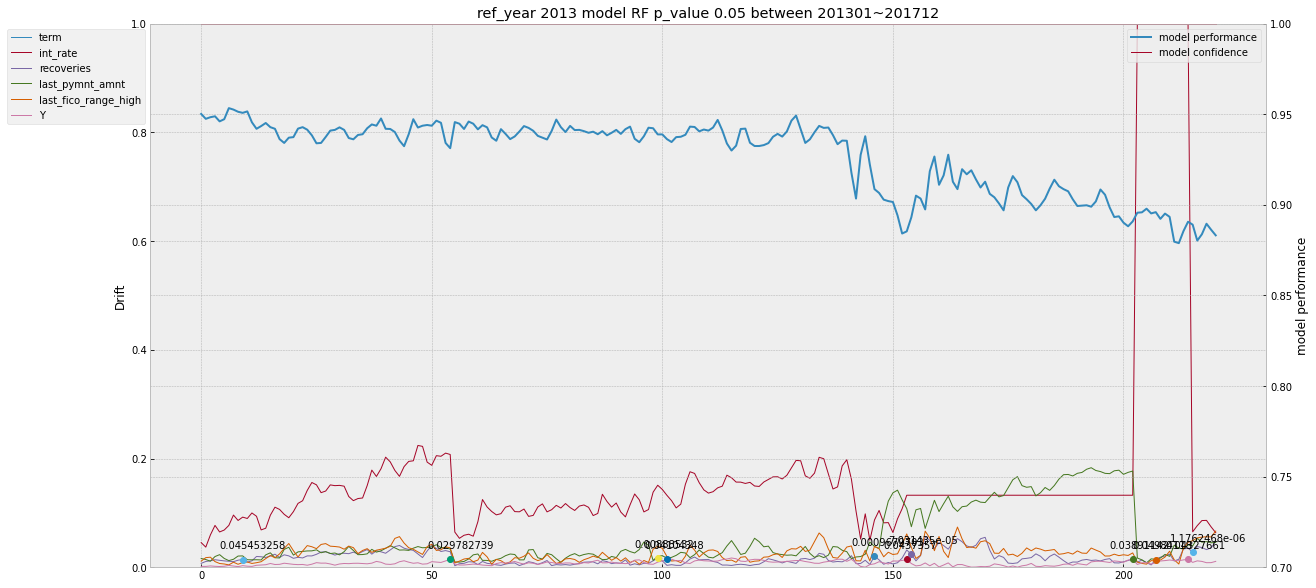

In [ ]:
plot_drift(scan_result,span = 1)

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']
============================== Drift detect from year 2009 ==============================
 1280000/1281415 step 257 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8834 cfd 1.0000

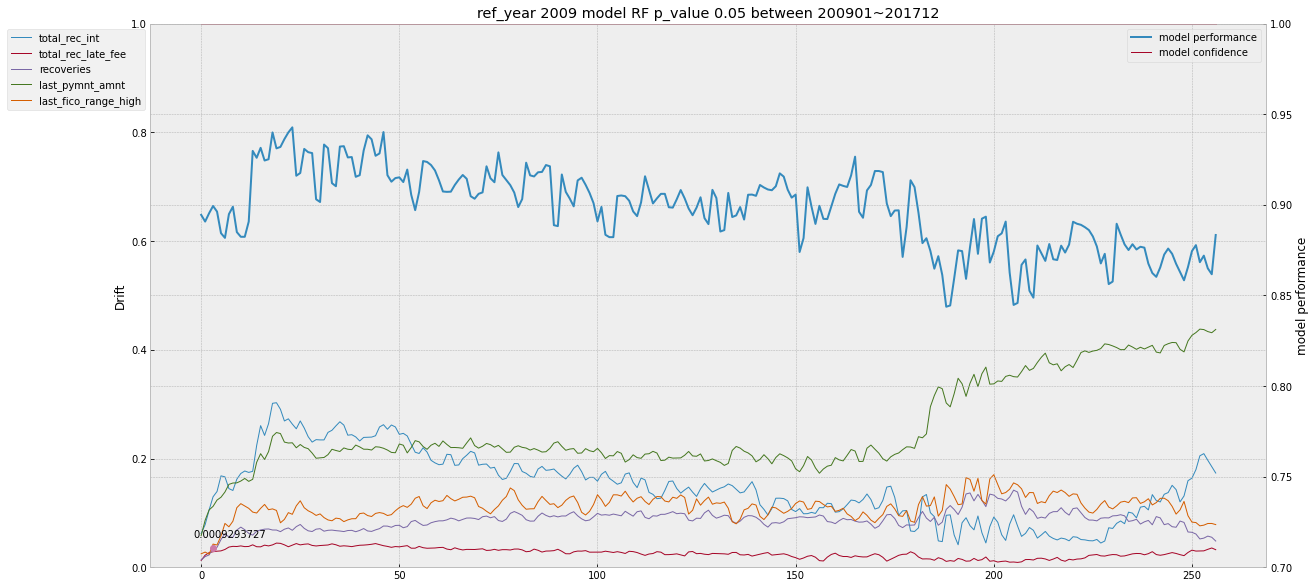

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']
============================== Drift detect from year 2009 ==============================
 15000/1281415 step 4 day 201102 index 29061 model_ver 0 drift 5 acc 0.8994 cfd 1.0000
================================================== Train ==================================================
new reference data index 1109~29061, length 27953
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate']

 35000/1281415 step 8 day 201201 index 49061 model_ver 1 drift 5 acc 0.8619 cfd 1.0000
================================================== Train ==================================================
new reference data index 1109~49061, length 47953
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'Y']

 610000/1281415 step 123 day 201507 index 624061 model_ver 2 drift 5 acc 0.9268 cfd 1.0

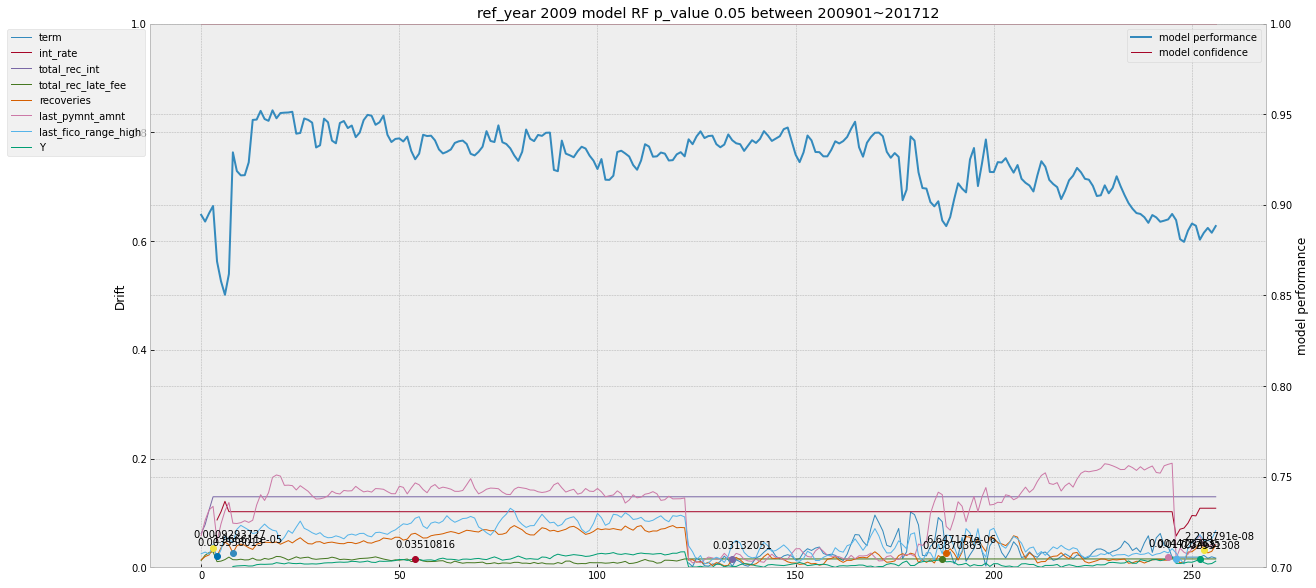

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']
============================== Drift detect from year 2010 ==============================
 1270000/1271697 step 255 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8721 cfd 1.0000

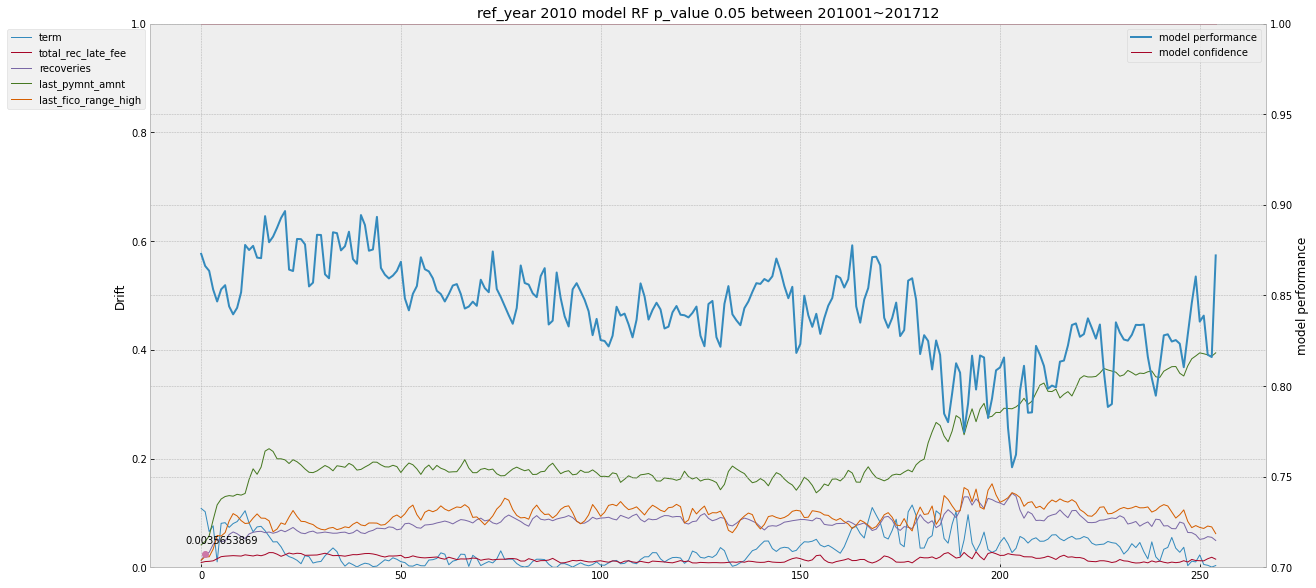

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']
============================== Drift detect from year 2010 ==============================
 25000/1271697 step 6 day 201112 index 48779 model_ver 0 drift 5 acc 0.8534 cfd 1.0000
================================================== Train ==================================================
new reference data index 5797~48779, length 42983
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate']

 85000/1271697 step 18 day 201301 index 108779 model_ver 1 drift 5 acc 0.9526 cfd 1.0000
================================================== Train ==================================================
new reference data index 5797~108779, length 102983
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']

 450000/1271697 step 91 day 201501 index 473779 model_ver 2 drift 5 acc 0.9281 cfd 1.0000

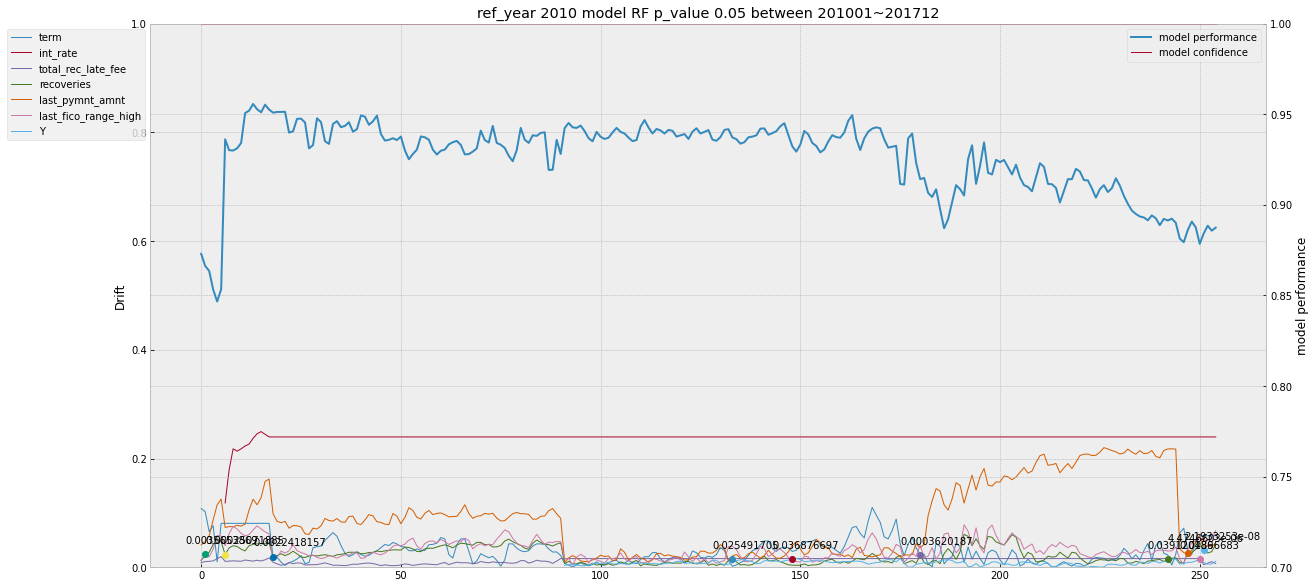

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'term', 'int_rate']
============================== Drift detect from year 2011 ==============================
 1250000/1253113 step 251 day 201712 index 1285476 model_ver 0 drift 5 acc 0.8799 cfd 1.0000

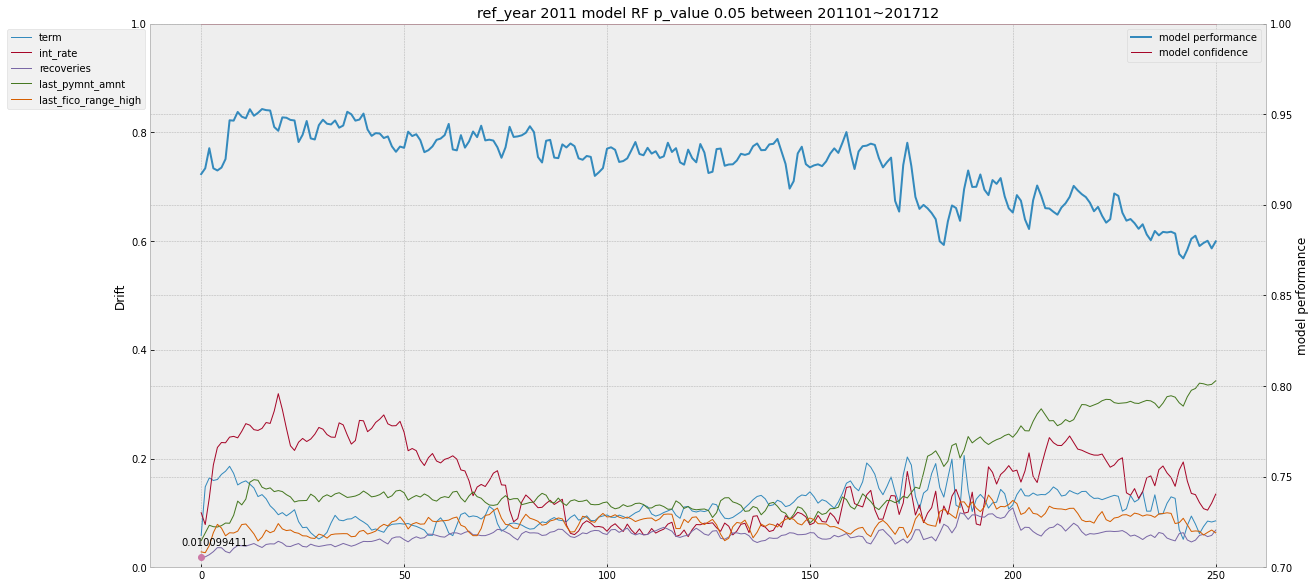

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'term', 'int_rate']
============================== Drift detect from year 2011 ==============================
 0/1253113 step 1 day 201110 index 42363 model_ver 0 drift 5 acc 0.9170 cfd 1.0000
================================================== Train ==================================================
new reference data index 17294~42363, length 25070
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'term', 'total_rec_late_fee']

 435000/1253113 step 88 day 201501 index 477363 model_ver 1 drift 5 acc 0.9246 cfd 1.0000
================================================== Train ==================================================
new reference data index 17294~477363, length 460070
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 860000/1253113 step 173 day 201603 index 902363 model_ver 2 drift 5 acc 0.9024 cfd 1.0000
==============================

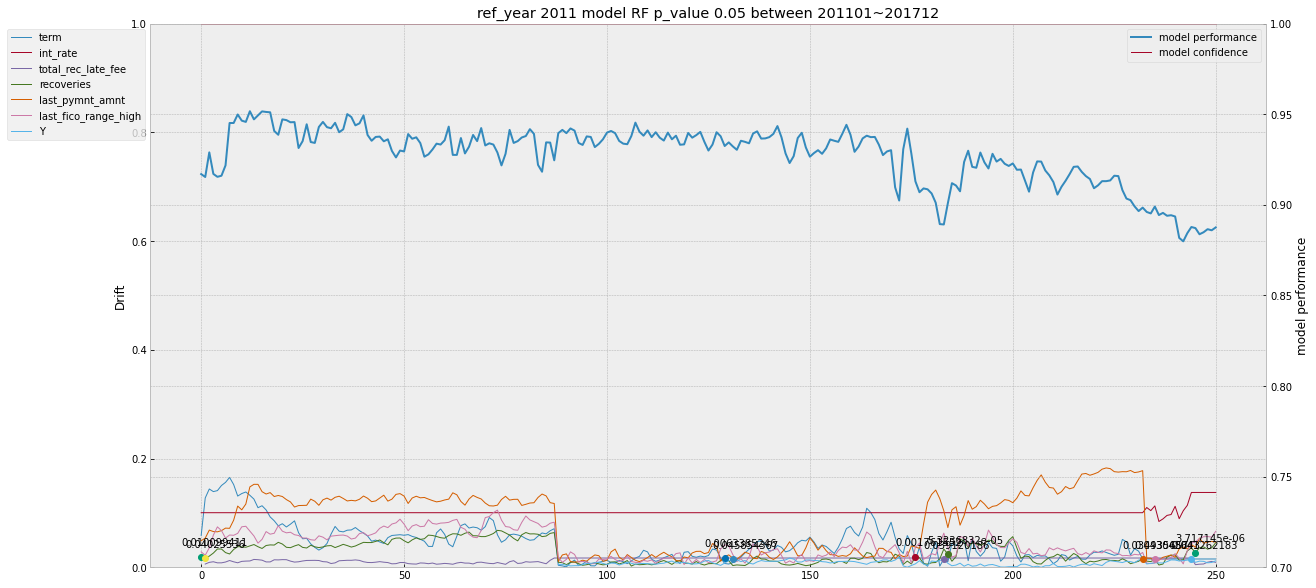

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2012 ==============================
 1210000/1211924 step 243 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8831 cfd 1.0000

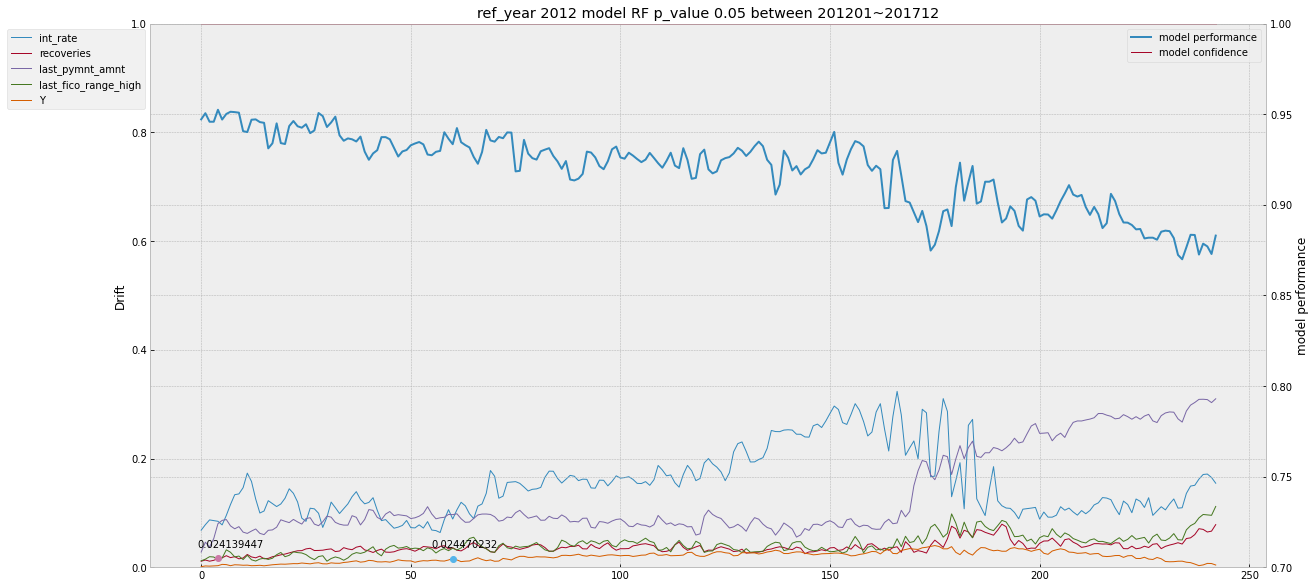

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2012 ==============================
 300000/1211924 step 61 day 201409 index 383552 model_ver 0 drift 5 acc 0.9335 cfd 1.0000
================================================== Train ==================================================
new reference data index 38969~383552, length 344584
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 645000/1211924 step 130 day 201510 index 728552 model_ver 1 drift 5 acc 0.9396 cfd 1.0000
================================================== Train ==================================================
new reference data index 38969~728552, length 689584
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']

 870000/1211924 step 175 day 201604 index 953552 model_ver 2 drift 5 acc 0.8841 cfd 1.0000
====================================

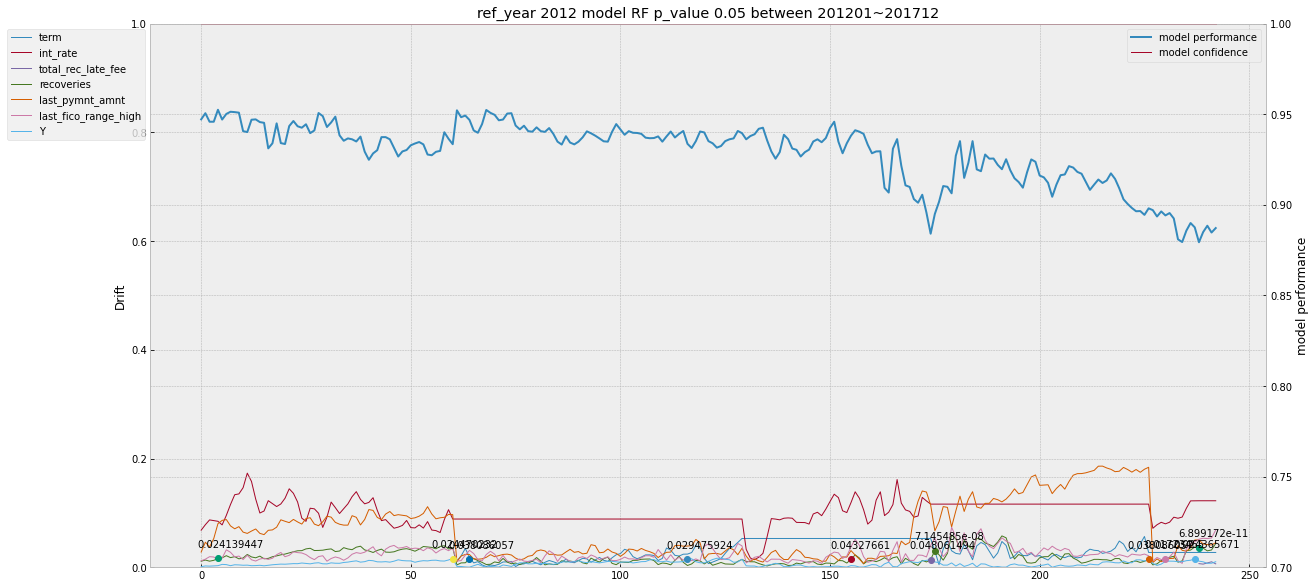

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2013 ==============================
 1100000/1102423 step 221 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8770 cfd 1.0000

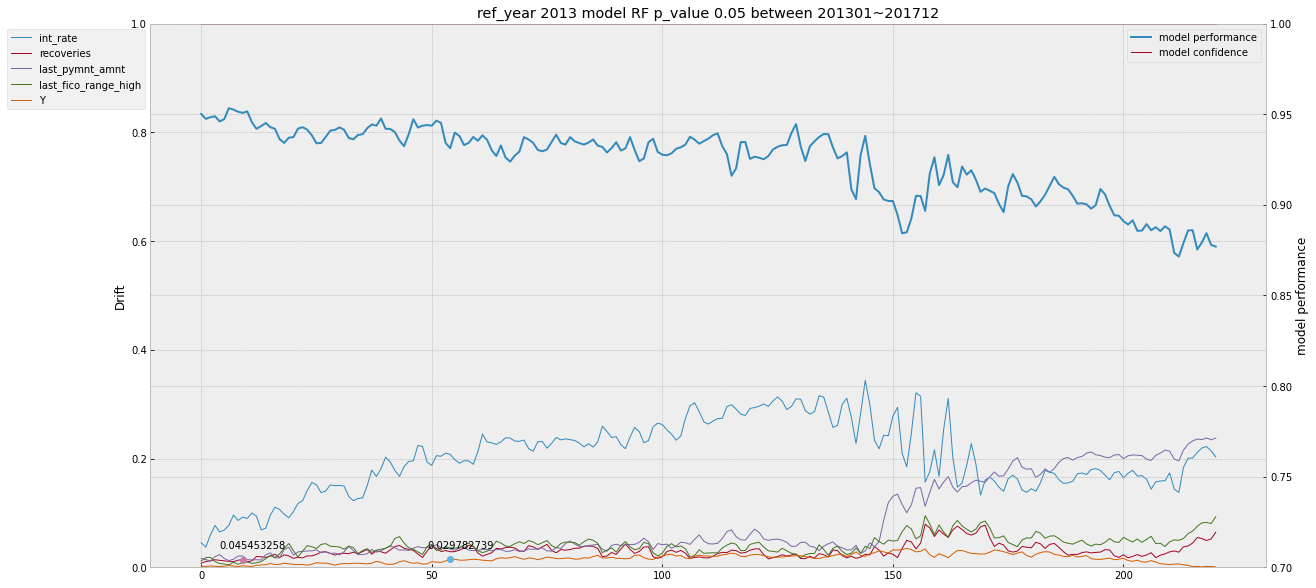

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2013 ==============================
 270000/1102423 step 55 day 201501 index 463053 model_ver 0 drift 5 acc 0.9313 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~463053, length 370825
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 705000/1102423 step 142 day 201603 index 898053 model_ver 1 drift 5 acc 0.9135 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~898053, length 805825
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 765000/1102423 step 154 day 201604 index 958053 model_ver 2 drift 5 acc 0.8932 cfd 1.0000
========================================

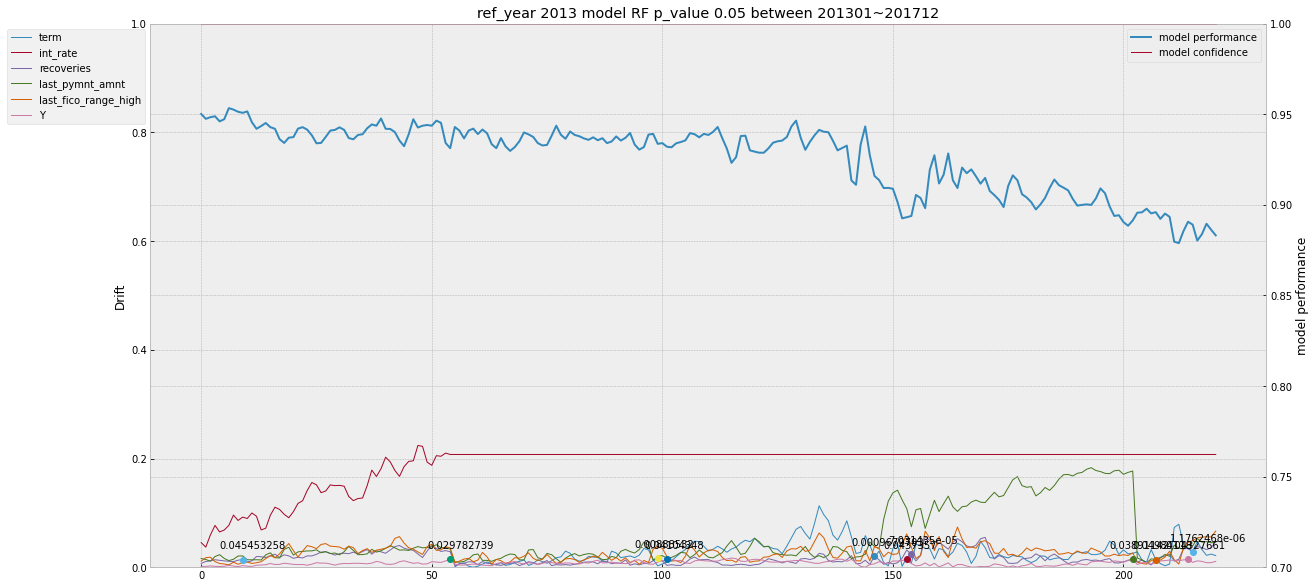

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2014 ==============================
 900000/904102 step 181 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8903 cfd 1.0000

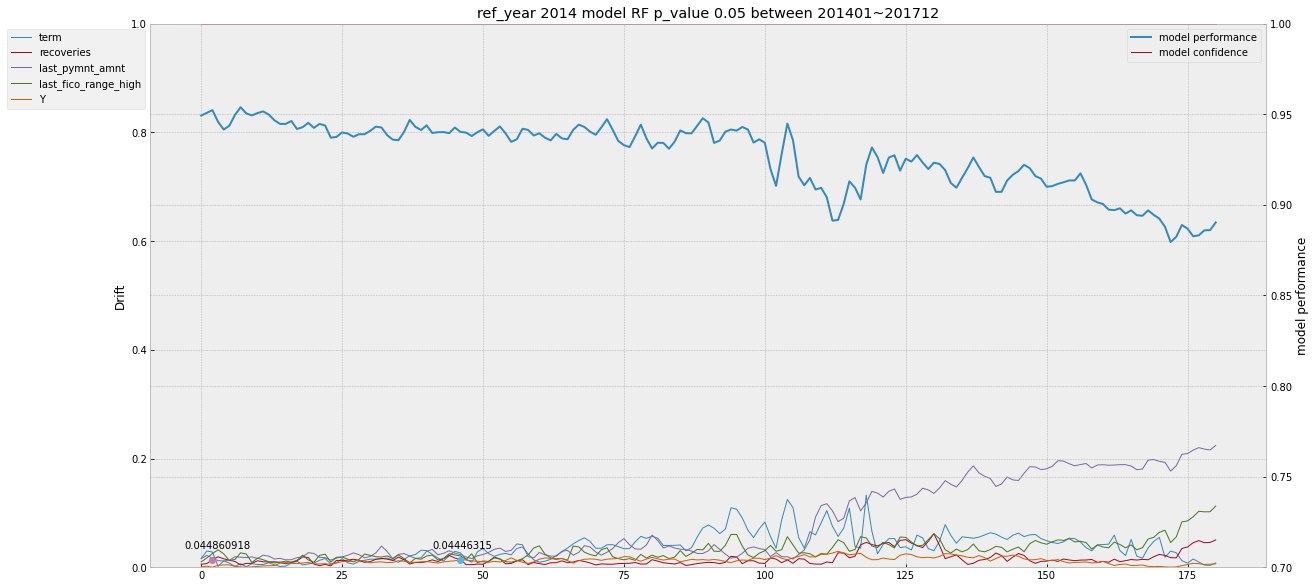

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2014 ==============================
 230000/904102 step 47 day 201506 index 621374 model_ver 0 drift 5 acc 0.9403 cfd 1.0000
================================================== Train ==================================================
new reference data index 226855~621374, length 394520
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 565000/904102 step 114 day 201604 index 956374 model_ver 1 drift 5 acc 0.8918 cfd 1.0000
================================================== Train ==================================================
new reference data index 226855~956374, length 729520
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 810000/904102 step 163 day 201705 index 1201374 model_ver 2 drift 5 acc 0.8967 cfd 1.0000
============================================

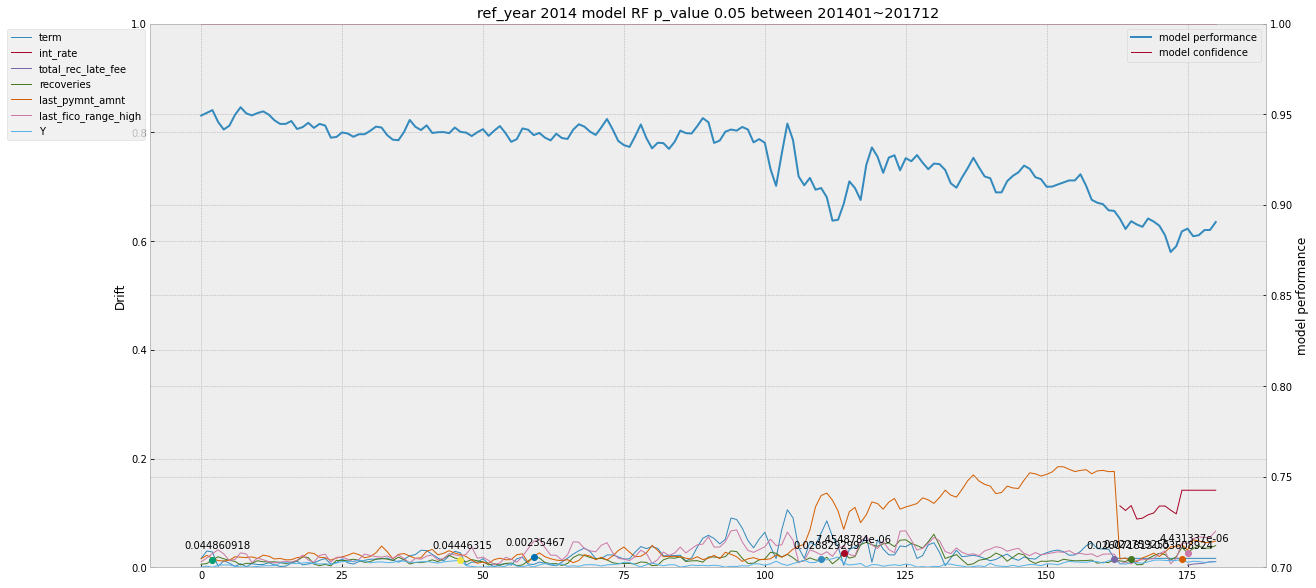

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2015 ==============================
 575000/575468 step 116 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8675 cfd 1.0000

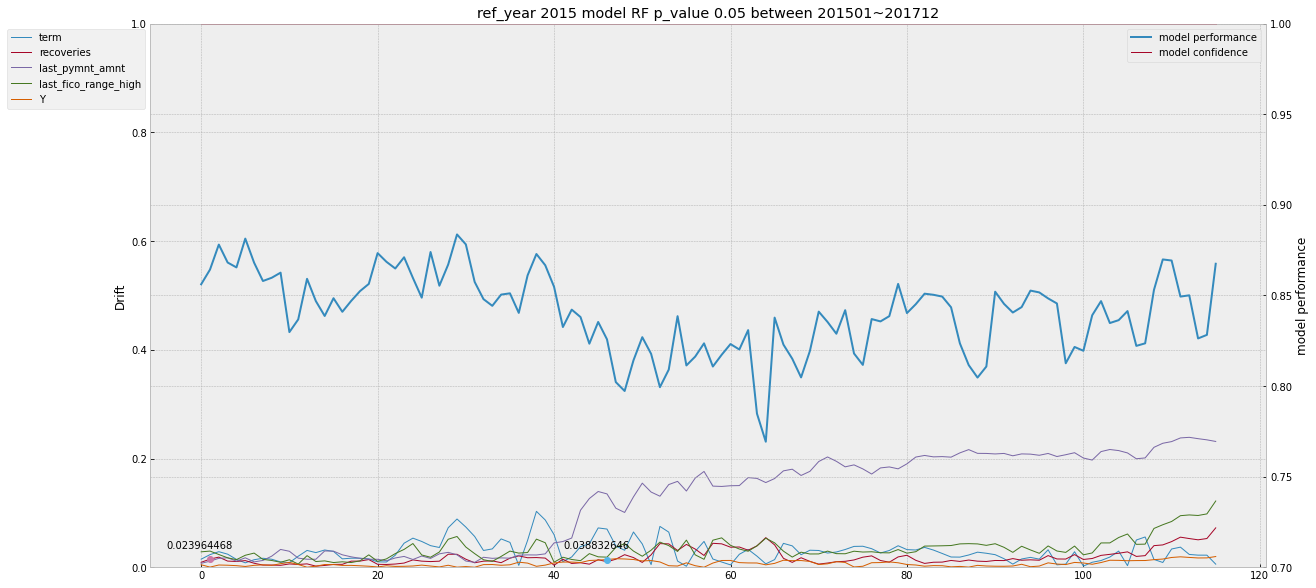

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2015 ==============================
 235000/575468 step 48 day 201604 index 955008 model_ver 0 drift 5 acc 0.8022 cfd 1.0000
================================================== Train ==================================================
new reference data index 449677~955008, length 505332
monitoring_feature ['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'Y', 'term']

 495000/575468 step 100 day 201706 index 1215008 model_ver 1 drift 5 acc 0.7964 cfd 1.0000
================================================== Train ==================================================
new reference data index 449677~1215008, length 765332
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']

 550000/575468 step 111 day 201710 index 1270008 model_ver 2 drift 5 acc 0.8138 cfd 1.0000
======================================

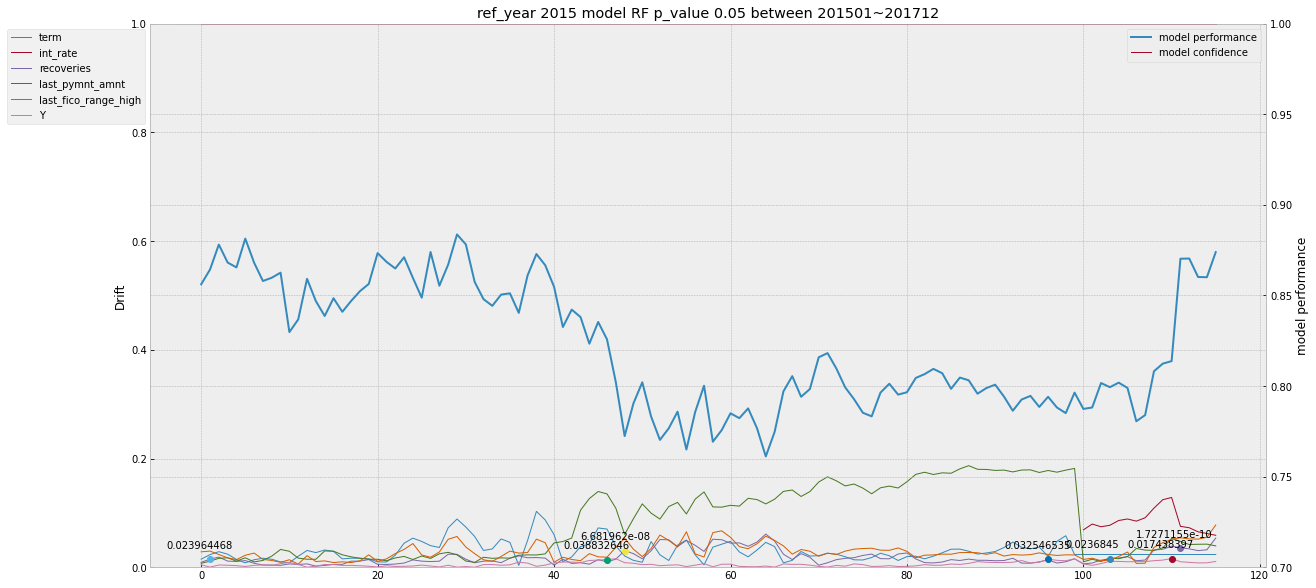

monitoring_feature ['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'Y', 'total_rec_late_fee']
============================== Drift detect from year 2016 ==============================
 225000/225511 step 46 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8865 cfd 1.0000

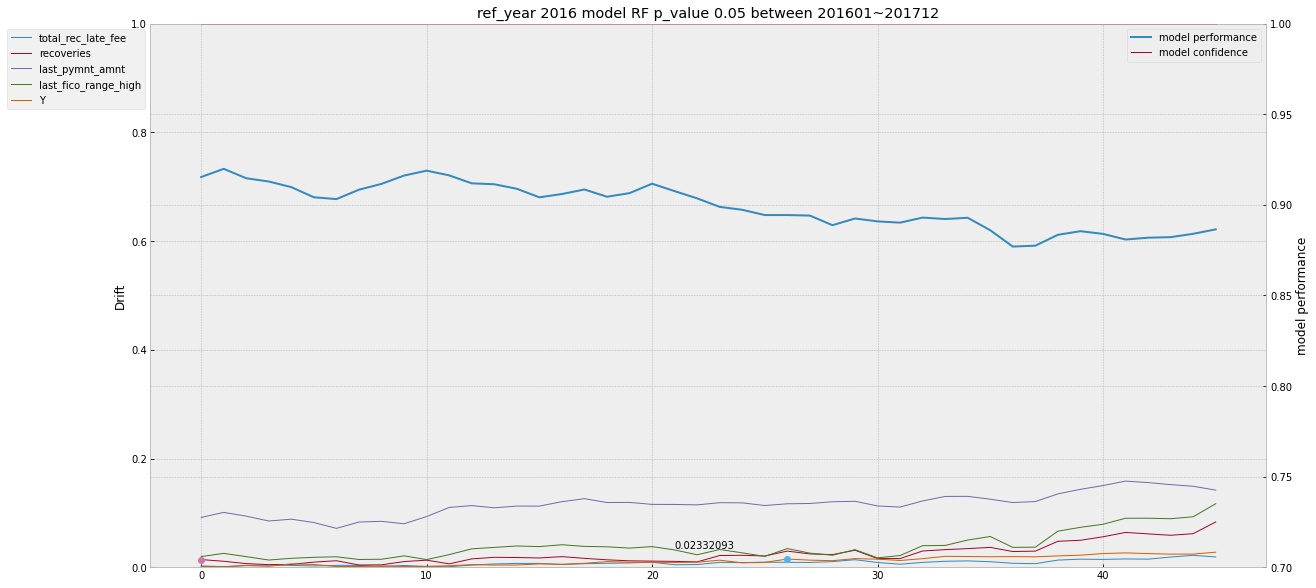

monitoring_feature ['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'Y', 'total_rec_late_fee']
============================== Drift detect from year 2016 ==============================
 145000/225511 step 30 day 201706 index 1214965 model_ver 0 drift 5 acc 0.8925 cfd 1.0000
================================================== Train ==================================================
new reference data index 824765~1214965, length 390201
monitoring_feature ['last_fico_range_high', 'last_pymnt_amnt', 'recoveries', 'Y', 'total_rec_late_fee']

 225000/225511 step 46 day 201712 index 1285476 model_ver 1 drift 2 acc 0.8885 cfd 1.0000

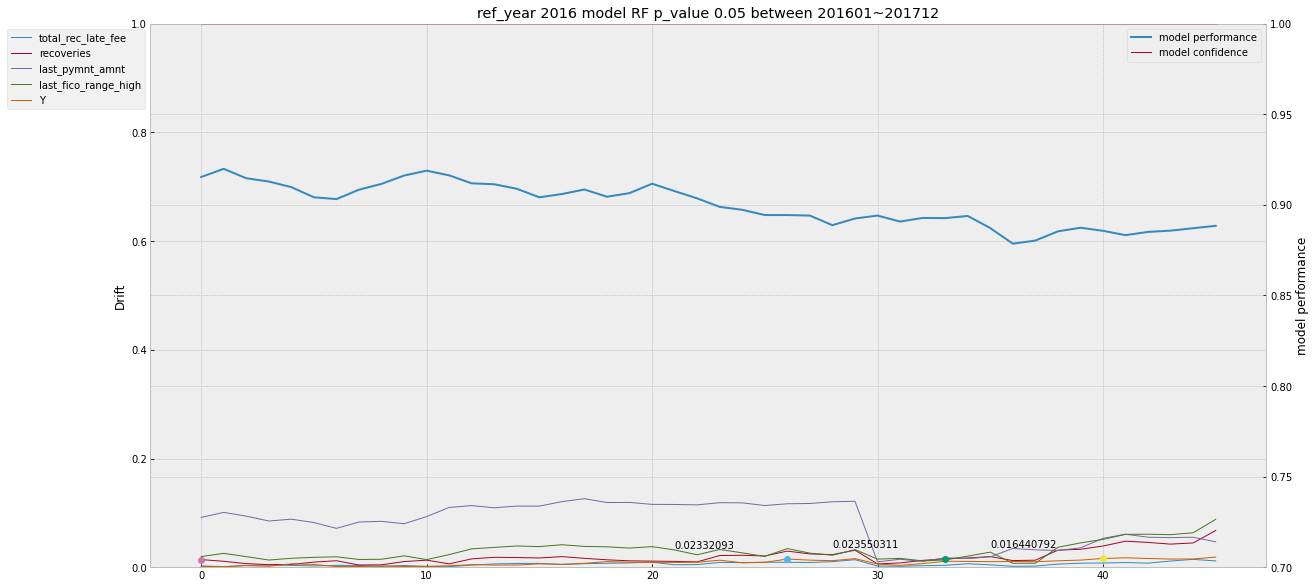

In [ ]:
#MODEL_TYPE='RF'
#build_models()
for year in range(2009,2017):
    REFERENCE_YEAR = year

    scan_result = scan_data2(detect_p_val=0.05,is_do_retrain=False)
    plot_drift(scan_result,span = 1)
    scan_result = scan_data2(detect_p_val=0.05,is_do_retrain=True)
    plot_drift(scan_result,span = 1)


재학습을 일정 사이즈로... 즉, 최신의 데이터 위주로 학습하는...

In [ ]:
import pickle

def scan_data3(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]

    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=x_columns)

    feature_importance = {}
    for (fname,imp_val) in forest_importances.items():
        feature_importance[fname] = (imp_val,0,0,0) 
    monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
    print('monitoring_feature',monitoring_feature)
    #feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR])

    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)
    #model_cd = ClassifierDrift(scaler.fit_transform(df_reference.drop(columns=['issue_d','loan_paid']).values), model, p_val=.05, train_size=.75, epochs=1)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in x_columns:
        result_data[column] = []
        #result_data[column + ' Drift'] = []
        #result_data[column + ' p_val'] = []
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 5000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname].append(stat_val)
            #result_data[fname + ' Drift'].append(is_drift)
            #result_data[fname + ' p_val'].append(p_val)

            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 
            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname])-1,stat_val),p_val]

        for fname in x_columns:
            if fname not in monitoring_feature:
                result_data[fname].append(None)
                #result_data[fname + ' Drift'].append(None)
                #result_data[fname + ' p_val'].append(None)

        drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())

        x_h0 = scaler.fit_transform(x_test_for_model)
        '''
        preds = model_cd.predict(x_h0)
        print(preds)
        '''
        predict_out = model.predict(x_h0)

        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')

            '''
            # ref year의 데이터와 최근 20만건의 데이터를 합하여, 썩는다.
            df_model_ref = pd.concat([df_accepted[df_accepted['issue_d'].str.endswith(str(REFERENCE_YEAR))],df_reference[-200000:]])
            df_model_ref = df_model_ref.sample(frac=1)
            '''
            df_ref_tmp = df_reference[-10000:]
            y = df_ref_tmp.loan_paid.values
            x = df_ref_tmp.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)

            importances = model.feature_importances_
            forest_importances = pd.Series(importances, index=x_columns)
            monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
            print('monitoring_feature',monitoring_feature)

            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].to_numpy()[-100000:]
            cd = KSDrift(drift_ref, p_val=detect_p_val)

            retrain_count += 1
            print()


    with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
        pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val]

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']
============================== Drift detect from year 2009 ==============================
 1280000/1281415 step 257 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8834 cfd 1.0000

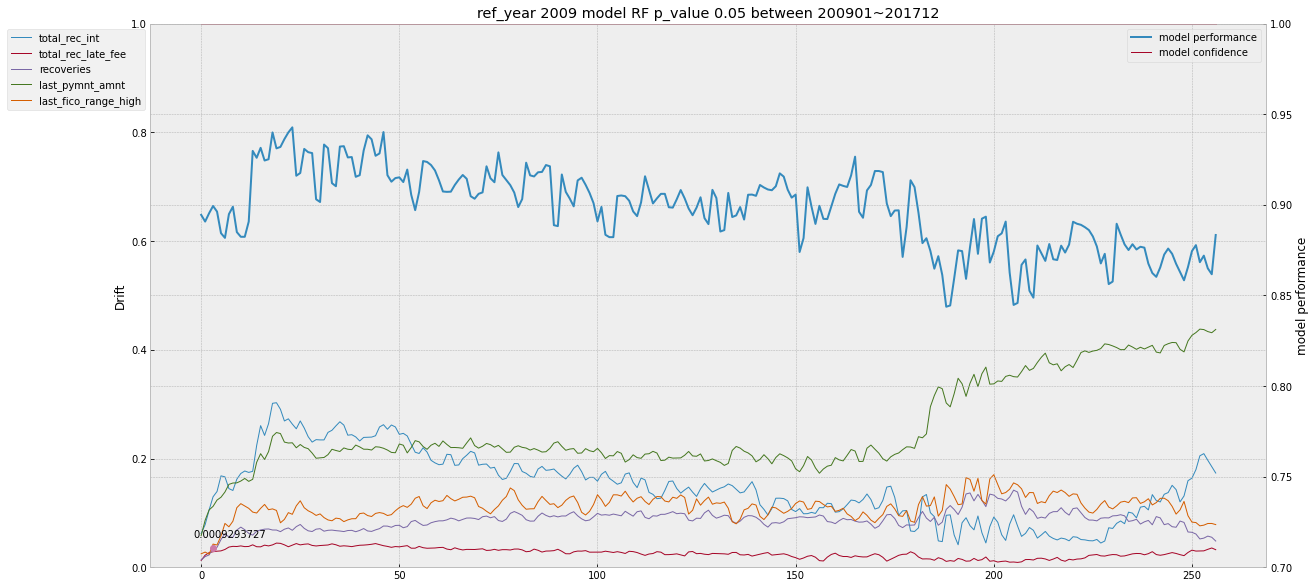

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']
============================== Drift detect from year 2009 ==============================
 15000/1281415 step 4 day 201102 index 29061 model_ver 0 drift 5 acc 0.8994 cfd 1.0000
================================================== Train ==================================================
new reference data index 1109~29061, length 27953
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']

 35000/1281415 step 8 day 201201 index 49061 model_ver 1 drift 5 acc 0.8786 cfd 1.0000
================================================== Train ==================================================
new reference data index 1109~49061, length 47953
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'int_rate', 'term']

 40000/1281415 step 9 day 201202 index 54061 model_ver 2 drift 5 acc 0.8595 cfd 1.0000
===========

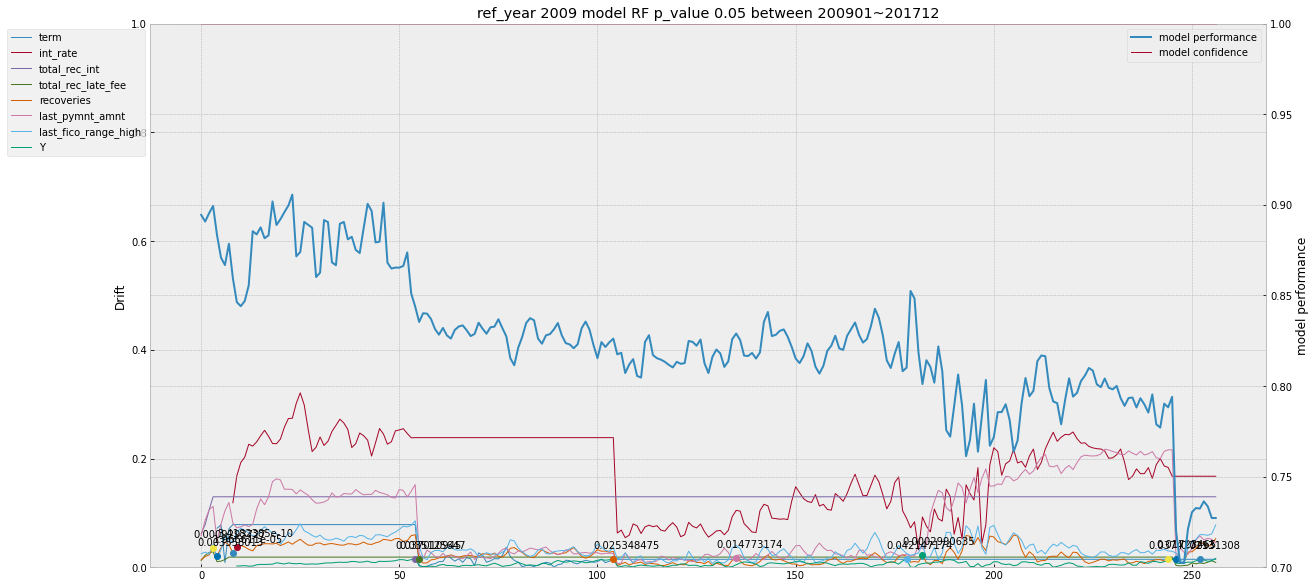

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']
============================== Drift detect from year 2010 ==============================
 1270000/1271697 step 255 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8721 cfd 1.0000

KeyboardInterrupt: ignored

In [ ]:
#MODEL_TYPE='RF'
#build_models()
for year in range(2009,2017):
    REFERENCE_YEAR = year

    scan_result = scan_data3(detect_p_val=0.05,is_do_retrain=False)
    plot_drift(scan_result,span = 1)
    scan_result = scan_data3(detect_p_val=0.05,is_do_retrain=True)
    plot_drift(scan_result,span = 1)